In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import image

import itertools
import random

tf.random.set_seed(1)

In [65]:
class CTCLoss(tf.keras.losses.Loss):
    def __init__(self, logits_time_major=False, blank_index=-1, 
                 reduction=tf.keras.losses.Reduction.AUTO, name='ctc_loss'):
        super().__init__(reduction=reduction, name=name)
        self.logits_time_major = logits_time_major
        self.blank_index = blank_index

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        logit_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
        print(f'y_true = {y_true}')
        print(f'y_pred = {y_pred}')
        print(f'logit_length = {logit_length}')
        print(f'logits_time_major = {self.logits_time_major}')
        print(f'blank_index = {self.blank_index}')
        loss = tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=None,
            logit_length=logit_length,
            logits_time_major=self.logits_time_major,
            blank_index=self.blank_index)
        print('made it here')
        return tf.reduce_mean(loss)

In [3]:
class SequenceAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name='sequence_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.total = self.add_weight(name='total', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')
                
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_shape = tf.shape(y_true)
        batch_size = y_true_shape[0]
        y_pred_shape = tf.shape(y_pred)
        max_width = tf.maximum(y_true_shape[1], y_pred_shape[1])
        logit_length = tf.fill([batch_size], y_pred_shape[1])      
        decoded, _ = tf.nn.ctc_greedy_decoder(
            inputs=tf.transpose(y_pred, perm=[1, 0, 2]),
            sequence_length=logit_length)
        y_true = self.to_dense(y_true, [batch_size, max_width])
        y_pred = self.to_dense(decoded[0], [batch_size, max_width])
        num_errors = tf.math.reduce_any(
            tf.math.not_equal(y_true, y_pred), axis=1)
        num_errors = tf.cast(num_errors, tf.float32)
        num_errors = tf.reduce_sum(num_errors)
        batch_size = tf.cast(batch_size, tf.float32)
        self.total.assign_add(batch_size)
        self.count.assign_add(batch_size - num_errors)

    def to_dense(self, tensor, shape):
        tensor = tf.sparse.reset_shape(tensor, shape)
        tensor = tf.sparse.to_dense(tensor, default_value=-1)
        tensor = tf.cast(tensor, tf.float32)
        return tensor

    def result(self):
        return self.count / self.total

    def reset_states(self):
        self.count.assign(0)
        self.total.assign(0)

In [4]:
import cv2
import os

def load_images_from_folder(folder, n_imgs=-1):
    images = []
    image_nums = []
    for filename in os.listdir(folder)[:n_imgs]:
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
            image_nums.append(filename.strip('.png'))
    return images, image_nums

folder="../../../Math Equations/linear_fcns/images"

In [5]:
images, fnames = load_images_from_folder(folder,18000)

In [6]:
labels = pd.read_csv('../../../Math Equations/linear_fcns/data.csv')
labels['img_number'] = labels['filename'].apply(lambda x: x.split('/')[-1].strip('.png'))

In [7]:
label_array = labels[labels['img_number'].isin(fnames)]['latex'].values
label_array = [f'\t{la}\n' for la in label_array]

In [8]:
images = np.array(images)
images = 255 - images

In [9]:
#images = tf.image.resize_with_pad(images, 72, 225)

In [10]:
#images = np.array(images)

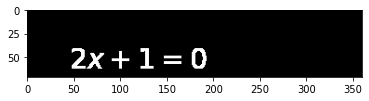

In [11]:
plt.imshow(images[0])

In [12]:
img_train, img_test, img_train_name, img_test_name = train_test_split(images, label_array, test_size=.2)

In [13]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [14]:
# Choose the top 5000 words from the vocabulary
top_k = 41
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters=' ',
                                                  char_level=True)
tokenizer.fit_on_texts(img_train_name)#label_array)
train_seqs = tokenizer.texts_to_sequences(img_train_name)

# Padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(img_train_name)
test_seqs = tokenizer.texts_to_sequences(img_test_name)

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
cap_vector_val = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

In [15]:
tokenizer.get_config()

{'num_words': 41,
 'filters': ' ',
 'lower': True,
 'split': ' ',
 'char_level': True,
 'oov_token': '<unk>',
 'document_count': 14400,
 'word_counts': '{"\\t": 14400, "9": 4298, "w": 546, "+": 14400, "4": 4327, "=": 14400, "8": 4313, "\\n": 14400, "1": 4346, "h": 556, "5": 4293, "z": 555, "0": 4260, "2": 4313, "f": 571, "6": 4348, "d": 532, "3": 4350, "c": 563, "7": 4352, "e": 563, "x": 537, "t": 545, "b": 569, "o": 554, "v": 571, "j": 568, "u": 548, "s": 558, "a": 543, "q": 550, "y": 550, "p": 527, "n": 565, "r": 558, "l": 548, "k": 551, "i": 568, "g": 548, "m": 556}',
 'word_docs': '{"\\n": 14400, "8": 4313, "+": 14400, "\\t": 14400, "9": 4298, "=": 14400, "4": 4327, "w": 546, "5": 4293, "h": 556, "1": 4346, "2": 4313, "z": 555, "0": 4260, "f": 571, "d": 532, "6": 4348, "3": 4350, "c": 563, "7": 4352, "e": 563, "x": 537, "t": 545, "b": 569, "o": 554, "v": 571, "j": 568, "u": 548, "s": 558, "a": 543, "q": 550, "y": 550, "p": 527, "n": 565, "r": 558, "l": 548, "k": 551, "i": 568, "g":

In [16]:
conv_1 = Conv2D(64, kernel_size=(3, 3), strides=1,activation='linear',input_shape=(72,360,1),padding='same')
conv_2 = Conv2D(128, kernel_size=(3, 3),strides=1,activation='linear',padding='same')
conv_3 = Conv2D(256, kernel_size=(3, 3),strides=1,activation='linear',padding='same')
conv_4 = Conv2D(256, kernel_size=(3, 3),strides=1,activation='linear',padding='same')
conv_5 = Conv2D(512, kernel_size=(3, 3),strides=1,activation='linear',padding='same')
conv_6 = Conv2D(512, kernel_size=(3, 3),strides=1,activation='linear',padding='same')
conv_7 = Conv2D(512, kernel_size=(2, 2),strides=1,activation='linear',padding='same')

max_p_1 = MaxPooling2D((2, 2), strides=2, padding='same')
max_p_2 = MaxPooling2D((2, 2), strides=2, padding='same')
max_p_3 = MaxPooling2D((1, 2), strides=2, padding='same')
max_p_4 = MaxPooling2D((1, 2), strides=2, padding='same')

batch_N = BatchNormalization()

NameError: name 'Conv2D' is not defined

In [ ]:
model_cnn = Sequential()
model_cnn.add(conv_1)
model_cnn.add(max_p_1)
model_cnn.add(conv_2)
model_cnn.add(max_p_2)
model_cnn.add(conv_3)
model_cnn.add(conv_4)
model_cnn.add(max_p_3)
model_cnn.add(conv_5)
model_cnn.add(batch_N)
model_cnn.add(conv_6)
model_cnn.add(batch_N)
model_cnn.add(max_p_4)
model_cnn.add(conv_7)
model_cnn.add()

In [66]:
def vgg_style(x):
    """
    The original feature extraction structure from CRNN paper.
    Related paper: https://ieeexplore.ieee.org/abstract/document/7801919
    """
    x = layers.Conv2D(
        64, 3, padding='same', activation='relu', name='conv1')(x)
    x = layers.MaxPool2D(pool_size=2, padding='same', name='pool1')(x)

    x = layers.Conv2D(
        128, 3, padding='same', activation='relu', name='conv2')(x)
    x = layers.MaxPool2D(pool_size=2, padding='same', name='pool2')(x)

    x = layers.Conv2D(256, 3, padding='same', use_bias=False, name='conv3')(x)
    x = layers.BatchNormalization(name='bn3')(x)
    x = layers.Activation('relu', name='relu3')(x)
    x = layers.Conv2D(
        256, 3, padding='same', activation='relu', name='conv4')(x)
    x = layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool4')(x)

    x = layers.Conv2D(512, 3, padding='same', use_bias=False, name='conv5')(x)
    x = layers.BatchNormalization(name='bn5')(x)
    x = layers.Activation('relu', name='relu5')(x)
    x = layers.Conv2D(
        512, 3, padding='same', activation='relu', name='conv6')(x)
    x = layers.MaxPool2D(
        pool_size=2, strides=(2, 1), padding='same', name='pool6')(x)

    x = layers.Conv2D(512, 2, use_bias=False, name='conv7')(x)
    x = layers.BatchNormalization(name='bn7')(x)
    x = layers.Activation('relu', name='relu7')(x)

    x = layers.Reshape((-1, 512), name='reshape7')(x)
    return x


def build_model(num_classes, img_shape=(72, 360, 3)):
    """ build CNN-RNN model """

    img_input = tf.keras.Input(shape=img_shape)
    #x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(img_input)
    
    x = vgg_style(img_input)

    x = layers.Bidirectional(
        layers.LSTM(units=256, return_sequences=True), name='bi_lstm1')(x)
    x = layers.Bidirectional(
        layers.LSTM(units=256, return_sequences=True), name='bi_lstm2')(x)
    logits = layers.Dense(units=num_classes, name='fc1')(x)
    return tf.keras.Model(inputs=img_input, outputs=logits, name='CRNN')

In [67]:
model = build_model(num_classes = 41)

model.compile(optimizer='adam', loss=CTCLoss(), metrics=[SequenceAccuracy()])

In [68]:
image_ds = tf.data.Dataset.from_tensors((img_train, img_train_name))
val_ds = tf.data.Dataset.from_tensors((img_test, img_test_name))

In [69]:
model.fit(img_train, cap_vector, epochs=20, validation_split=.2)

Epoch 1/20
y_true = Tensor("IteratorGetNext:1", shape=(32, 8), dtype=int32)
y_pred = Tensor("CRNN/fc1/BiasAdd:0", shape=(32, 356, 41), dtype=float32)
logit_length = Tensor("ctc_loss/Fill:0", shape=(32,), dtype=int32)
logits_time_major = False
blank_index = -1


ValueError: in user code:

    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-65-6ae549f2157f>:16 call  *
        loss = tf.nn.ctc_loss(
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper  **
        return target(*args, **kwargs)
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/ctc_ops.py:936 ctc_loss_v3
        name=name)
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/ctc_ops.py:1008 ctc_loss_dense
        label_length = ops.convert_to_tensor(label_length, name="label_length")
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1499 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:338 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:264 constant
        allow_broadcast=True)
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:282 _constant_impl
        allow_broadcast=allow_broadcast))
    /opt/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:444 make_tensor_proto
        raise ValueError("None values not supported.")

    ValueError: None values not supported.


In [38]:
image_ds

<TensorDataset shapes: ((14400, 72, 360, 3), (14400,)), types: (tf.uint8, tf.string)>

In [33]:
cap_vector.shape

(14400, 8)

In [35]:
img_train_name[0]

'\t9w+4=8\n'

In [70]:
model.summary()

Model: "CRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 72, 360, 3)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 72, 360, 64)       1792      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 36, 180, 64)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 36, 180, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 18, 90, 128)       0         
_________________________________________________________________
conv3 (Conv2D)               (None, 18, 90, 256)       294912    
_________________________________________________________________
bn3 (BatchNormalization)     (None, 18, 90, 256)       1024   